In [ ]:
# Colab setup

from google.colab import drive
drive.mount("/content/drive/")

%cd "/content/drive/MyDrive/PACS/APSC_project (do not delete!)/bayesian_network/examples/2_brain_damage_recovery"

try:
    from dlroms import *
except:
    !pip install git+https://github.com/NicolaRFranco/dlroms.git
    from dlroms import *

In [ ]:
import os
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from dlroms import *
import gmsh
import sys
from IPython.display import clear_output as clc
sys.path.append(os.path.join("..", "..", "dlroms")) # TODO: better alternative?
from bayesian import *
# import bayesian
# %load_ext autoreload
# %autoreload 2

In [ ]:
# Setup

gmsh.initialize()

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.manual_seed(0) # TODO: change seed initialization

In [ ]:
# Domain definition

loop = lambda v: np.concatenate((v, v[[0]]))
brain = np.load(os.path.join('brain_meshes', 'brainshape.npz'))
domain = fe.polygon(loop(brain['main'][::9])) - fe.polygon(loop(brain['hole1'][::9])) - fe.polygon(loop(brain['hole2'][::8]))

# Mesh and function space definition

mesh_H = fe.loadmesh(os.path.join('brain_meshes', 'brain-mesh40.xml'))
Vh_H = fe.space(mesh_H, 'CG', 1)
h_H, nh_H = mesh_H.hmax(), Vh_H.dim()

mesh_C = fe.loadmesh(os.path.join('brain_meshes', 'brain-mesh15.xml'))
Vh_C = fe.space(mesh_C, 'CG', 1)
h_C, nh_C = mesh_C.hmax(), Vh_C.dim()

clc()

In [ ]:
# Load snapshots

path_train = os.path.join('snapshots', 'snapshots_train.npz')
if not os.path.exists(path_train):
	print(f"Training snapshots not found at {path_train}.")
	exit()
data_train = np.load(path_train)
N_train = data_train['mu'].shape[0]
mu_train, u_train = data_train['mu'].astype(np.float32), data_train['u'].astype(np.float32)
mu_train, u_train = torch.tensor(mu_train).to(device), torch.tensor(u_train).to(device)

path_test = os.path.join('snapshots', 'snapshots_test.npz')
if not os.path.exists(path_test):
	print(f"Test snapshots not found at {path_test}.")
	exit()
data_test = np.load(path_test)
N_test = data_test['mu'].shape[0]
mu_test, u_test = data_test['mu'].astype(np.float32), data_test['u'].astype(np.float32)
mu_test, u_test = torch.tensor(mu_test).to(device), torch.tensor(u_test).to(device)

In [ ]:
# Bayesian network training

layer_1 = Geodesic(domain, Vh_H, Vh_C, support=0.05) # default activation: leakyReLU
layer_2 = Geodesic(domain, Vh_C, Vh_C, support=0.1)
layer_3 = Geodesic(domain, Vh_C, Vh_H, support=0.05, activation=None)

l2 = L2(Vh_H)
clc()

model = DFNN(layer_1, layer_2, layer_3)

if torch.cuda.is_available():
	model.cuda()

model_bayes = Bayesian(model)
# model_bayes.He()

if torch.cuda.is_available():
	model_bayes.cuda()
	l2.cuda()

N_particles = 30

trainer = SVGD(model_bayes, lr=1e-2, n_samples=N_particles)
trainer.He()
model_bayes.set_trainer(trainer) # assign trainer to Bayesian model

In [ ]:
# model_bayes.train(mu_train, u_train, ntrain=N_train, nvalid=int(0.1*N_train), loss=mse(l2), epochs=2500)
model_bayes.train(mu_train, u_train, ntrain=N_train, loss=mse(l2), epochs=2500)

Epoch: 2500/2500, train: 0.000092, valid: nan test: nan: 100%|██████████| 2500/2500 [20:58<00:00,  1.99it/s]


In [ ]:
# Bayesian network evaluation

with torch.no_grad():
	u_pred_bayes_train_mean, u_pred_bayes_train_var = model_bayes.sample(mu_train, n_samples=N_particles)
	u_pred_bayes_mean, u_pred_bayes_var = model_bayes.sample(mu_test, n_samples=N_particles)

error_train_mean = mre(l2)(u_train, u_pred_bayes_train_mean)
error_test_mean = mre(l2)(u_test, u_pred_bayes_mean)
print(f"Relative train error: {100 * torch.mean(error_train_mean):.2f}%")
print(f"Relative test error: {100 * torch.mean(error_test_mean):.2f}%")

Relative train error: 9.54%
Relative test error: 10.10%


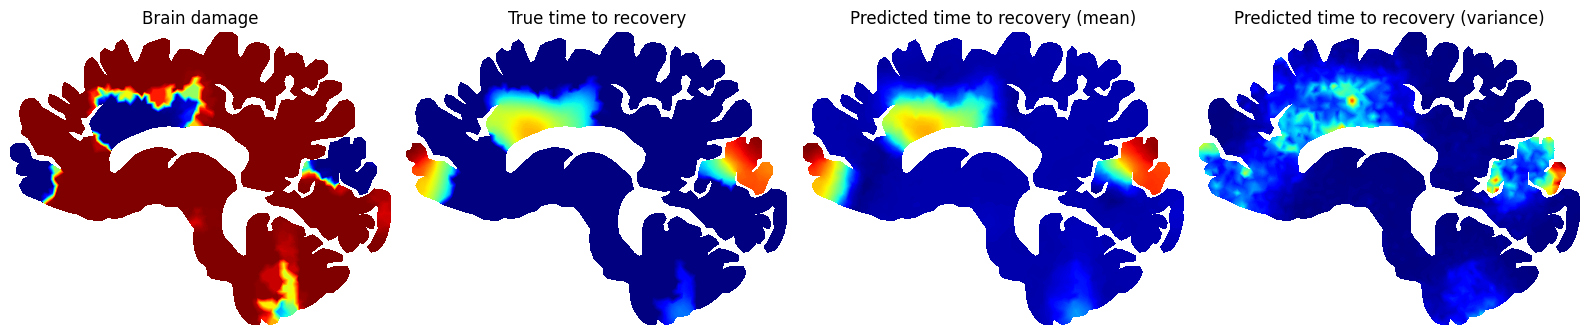

In [ ]:
# Plot a random snapshot

idx = 30

plt.figure(figsize=(16, 5))
plt.subplot(1, 4, 1)
plt.title("Brain damage")
fe.plot(1 + 0 * mu_test[idx], Vh_H, cmap='jet', vmin=0, vmax=1)
fe.plot(mu_test[idx], Vh_H, cmap='jet')
plt.subplot(1, 4, 2)
plt.title("True time to recovery")
fe.plot(u_test[idx], Vh_H, cmap='jet')
plt.subplot(1, 4, 3)
plt.title("Predicted time to recovery (mean)")
fe.plot(u_pred_bayes_mean[idx], Vh_H, cmap='jet')
plt.subplot(1, 4, 4)
plt.title("Predicted time to recovery (variance)")
fe.plot(u_pred_bayes_var[idx], Vh_H, cmap='jet')
plt.tight_layout()

In [ ]:
# Save trainer state

checkpoint_dir = 'checkpoints'
if not os.path.exists(checkpoint_dir):
	os.makedirs(checkpoint_dir)

trainer.save_particles(os.path.join(checkpoint_dir, 'particles_' + str(N_particles) + '.pth'))

In [ ]:
# from scipy import stats

# u_test_np = u_test.cpu().numpy().flatten()
# u_pred_bayes_mean_np = u_pred_bayes_mean.cpu().numpy().flatten()

# # Create a KDE estimate
# kde_u_test = stats.gaussian_kde(u_test_np)
# kde_u_pred_bayes_mean = stats.gaussian_kde(u_pred_bayes_mean_np)

# x = np.linspace(u_test_np.min(), u_test_np.max(), 1000)
# plt.plot(x, kde_u_test(x), label='true')
# plt.plot(x, kde_u_pred_bayes_mean(x), label='predicted')
# plt.legend()
# plt.show()

In [ ]:
# from scipy.stats import norm

# u_test_np = u_test.cpu().numpy().flatten()
# u_pred_bayes_mean_np = u_pred_bayes_mean.cpu().numpy().flatten()
# u_pred_bayes_var_np = u_pred_bayes_var.cpu().numpy().flatten()

# quantiles = np.linspace(0, 1, 100)

# calibration_curve = np.zeros_like(quantiles)

# for i in range(len(u_test_np)):
# 	normal_quantiles = norm.ppf(quantiles, loc=u_pred_bayes_mean_np[i], scale=np.sqrt(u_pred_bayes_var_np[i]))
# 	mask = (normal_quantiles > u_test_np[i])
# 	calibration_curve += mask

# calibration_curve /= len(u_test_np)

# plt.plot(quantiles, calibration_curve)
# plt.plot(quantiles, quantiles, '--')
# plt.show()